# Omnigot One-Shot with Virtual Branching

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import os
import matplotlib.pyplot as plt

1.13.1


In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
from vbranch.applications.resnet import ResNet18
from vbranch.applications.cnn import SimpleCNNLarge
from vbranch.datasets import omniglot

from vbranch.utils import *
from vbranch.callbacks import one_shot_acc
from vbranch.losses import triplet_omniglot

Using TensorFlow backend.


In [4]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'simple'
DATASET = 'omniglot'
NUM_BRANCHES = 4
SHARED_FRAC = 1.0

EPOCHS = 60
STEPS_PER_EPOCH = 100
T_0 = 40
OUTPUT_DIM = 128

## Load Data

In [5]:
class SyncGenerator(object):
    def __init__(self, A, P, K, n_branches):
        self.A = A
        self.P = P
        self.K = K
        self.n_branches = n_branches
        self.gen = omniglot.load_generator('train', A*n_branches, P, K)
        self.batch = None
        self.requests = 0
        
    def get(self, i):
        if self.batch is None:
            self.batch = next(self.gen)
            self.requests = self.n_branches
            
        branch_batch = self.batch[i*self.A*self.P*self.K:(i+1)*self.A*self.P*self.K]
        self.requests -= 1
        
        if self.requests == 0:
            self.batch = None
            
        return branch_batch
    
class Slicer(object):
    def __init__(self, parent, branch):
        self.parent = parent
        self.branch = branch
        
    def __next__(self):
        return self.parent.get(self.branch)

In [6]:
if DATASET == 'omniglot':
    A, P, K = 1, 8, 4
    train_generator = omniglot.load_generator('train', A*NUM_BRANCHES, P, K)

    sync_gen = SyncGenerator(A, P, K, NUM_BRANCHES)
    branch_gen = [Slicer(sync_gen, i) for i in range(NUM_BRANCHES)]

In [22]:
batch = next(branch_gen[3])

In [23]:
# batch = train_generator.sample(4, 4, 4, flatten=False, preprocess=False)

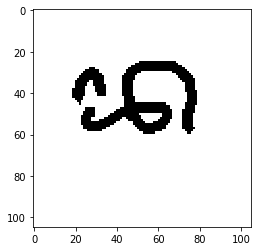

In [24]:
plt.imshow(batch[0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [9]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/vb-omniglot-simple-B4-S1.00_1


In [10]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

tf.reset_default_graph()

inputs, train_init_op, test_init_op = get_data_iterator_from_generator(branch_gen, input_dim, 
                                                                       n=NUM_BRANCHES)
# combined_input, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, 
#                                                                                input_dim, n=NUM_BRANCHES)
# inputs = [combined_input[0][i*A*P*K:(i+1)*A*P*K] for i in range(NUM_BRANCHES)]

(None, 105, 105, 1)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
inputs

[<tf.Tensor 'input_1:0' shape=(?, 105, 105, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 105, 105, 1) dtype=float32>,
 <tf.Tensor 'input_3:0' shape=(?, 105, 105, 1) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(?, 105, 105, 1) dtype=float32>]

In [12]:
lr = tf.placeholder('float32', name='lr')
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'res':
        model = ResNet18(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    # Compile model
    model.compile(optimizer, triplet_omniglot(A, P, K), 
                  train_init_op, test_init_op, 
                  callbacks={'acc': one_shot_acc(NUM_BRANCHES)}, 
                  schedulers={'lr:0': lr_scheduler})

model.summary()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                  
--------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                  
--------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                  
--------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                  
--------------------------------------------------------------------------------------
0   

In [13]:
print(model.output)

[<tf.Tensor 'model/output/vb1/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb2/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb3/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb4/output:0' shape=(?, 128) dtype=float32>]


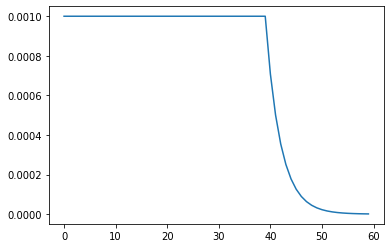

In [14]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [15]:
model.test_init_ops

[<tf.Operation 'test_init_op_1' type=MakeIterator>,
 <tf.Operation 'test_init_op_2' type=MakeIterator>,
 <tf.Operation 'test_init_op_3' type=MakeIterator>,
 <tf.Operation 'test_init_op_4' type=MakeIterator>]

In [16]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=None, 
                    log_path=model_path if SAVE else None)

Epoch 1/60
 - 29s - lr:0: 0.0010 - loss_1: 270.6875 - loss_2: 253.0603 - loss_3: 234.5373 - loss_4: 255.8024 - acc_ensemble: 0.5850 - acc_1: 0.5850 - acc_2: 0.5850 - acc_3: 0.5850 - acc_4: 0.5850
Epoch 2/60
 - 10s - lr:0: 0.0010 - loss_1: 70.6240 - loss_2: 74.9567 - loss_3: 66.8438 - loss_4: 70.3890 - acc_ensemble: 0.6800 - acc_1: 0.6800 - acc_2: 0.6800 - acc_3: 0.6800 - acc_4: 0.6800
Epoch 3/60
 - 10s - lr:0: 0.0010 - loss_1: 41.8302 - loss_2: 41.0904 - loss_3: 42.5982 - loss_4: 45.9606 - acc_ensemble: 0.7050 - acc_1: 0.7050 - acc_2: 0.7050 - acc_3: 0.7050 - acc_4: 0.7050
Epoch 4/60
 - 10s - lr:0: 0.0010 - loss_1: 42.7190 - loss_2: 41.0183 - loss_3: 46.9236 - loss_4: 45.6100 - acc_ensemble: 0.6950 - acc_1: 0.6950 - acc_2: 0.6950 - acc_3: 0.6950 - acc_4: 0.6950
Epoch 5/60
 - 10s - lr:0: 0.0010 - loss_1: 33.4798 - loss_2: 33.0463 - loss_3: 33.1161 - loss_4: 39.7262 - acc_ensemble: 0.7225 - acc_1: 0.7225 - acc_2: 0.7225 - acc_3: 0.7225 - acc_4: 0.7225
Epoch 6/60
 - 10s - lr:0: 0.0010 - l

Epoch 44/60
 - 10s - lr:0: 2.5119e-04 - loss_1: 3.0346 - loss_2: 2.7732 - loss_3: 3.8132 - loss_4: 2.6526 - acc_ensemble: 0.9425 - acc_1: 0.9425 - acc_2: 0.9425 - acc_3: 0.9425 - acc_4: 0.9425
Epoch 45/60
 - 10s - lr:0: 1.7783e-04 - loss_1: 2.4013 - loss_2: 2.8626 - loss_3: 2.3771 - loss_4: 3.8731 - acc_ensemble: 0.9375 - acc_1: 0.9375 - acc_2: 0.9375 - acc_3: 0.9375 - acc_4: 0.9375
Epoch 46/60
 - 10s - lr:0: 1.2589e-04 - loss_1: 2.6814 - loss_2: 2.5624 - loss_3: 3.0887 - loss_4: 2.8880 - acc_ensemble: 0.9475 - acc_1: 0.9475 - acc_2: 0.9475 - acc_3: 0.9475 - acc_4: 0.9475
Epoch 47/60
 - 10s - lr:0: 8.9125e-05 - loss_1: 3.3756 - loss_2: 3.1148 - loss_3: 2.2191 - loss_4: 2.9057 - acc_ensemble: 0.9475 - acc_1: 0.9475 - acc_2: 0.9475 - acc_3: 0.9475 - acc_4: 0.9475
Epoch 48/60
 - 10s - lr:0: 6.3096e-05 - loss_1: 3.1896 - loss_2: 2.2885 - loss_3: 2.7946 - loss_4: 2.4543 - acc_ensemble: 0.9400 - acc_1: 0.9400 - acc_2: 0.9400 - acc_3: 0.9400 - acc_4: 0.9400
Epoch 49/60
 - 10s - lr:0: 4.4668e-

## Evaluation

### Baseline

In [15]:
assert NUM_BRANCHES == 1

model_id_list = [1]
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_one_shot(sess, model_name='model_'+str(model_id))
        print('Model {} acc:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('Mean acc:', np.mean(baseline_acc_list), ', std:', np.std(baseline_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/omniglot-res_1/ckpt
Model 1 acc: 0.8049999999999999
Mean acc: 0.8049999999999999 , std: 0.0


### Virtual Branching

In [8]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)    
        acc, branch_acc = vbranch_one_shot(sess, model_name='model_'+str(model_id), 
                                           n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/vb-omniglot-res-B2-S0.25_1/ckpt
Model 1 acc: 0.8375 [0.7849999999999999, 0.8125]
Mean acc: 0.8375 , std: 0.0
